In [1]:
"""Example of using training on CartPole."""

#import argparse
import ray
from ray import tune
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel
from ray.rllib.contrib.alpha_zero.environments.cartpole import CartPole
from ray.rllib.models.catalog import ModelCatalog

train=False
#parser = argparse.ArgumentParser()
#parser.add_argument("--num-workers", default=6, type=int)
#parser.add_argument("--training-iteration", default=10000, type=int)
#parser.add_argument("--ray-num-cpus", default=7, type=int)
#args = parser.parse_args()
ray.shutdown()
ray.init(num_cpus=7)

ModelCatalog.register_custom_model("dense_model", DenseModel)

config={
    "env": CartPole,
    "num_workers": 0,
    "rollout_fragment_length": 50,
    "train_batch_size": 500,
    "sgd_minibatch_size": 64,
    "lr": 1e-4,
    "num_sgd_iter": 1,
    "mcts_config": {
        "puct_coefficient": 1.5,
        "num_simulations": 100,
        "temperature": 1.0,
        "dirichlet_epsilon": 0.20,
        "dirichlet_noise": 0.03,
        "argmax_tree_policy": False,
        "add_dirichlet_noise": True,
    },
    "ranked_rewards": {
        "enable": True,
    },
    "model": {
        "custom_model": "dense_model",
    },
}


In [2]:
if train:
    analysis=tune.run(
        "contrib/AlphaZero",
        local_dir="/Users/felix/sciebo/masterarbeit/progra/model-based_rl/tune_check",
        stop={"training_iteration": 2000},
        checkpoint_freq = 1,
        max_failures=0,
        config=config,
    )



In [3]:
from ray.rllib.contrib.alpha_zero.core.alpha_zero_trainer import AlphaZeroTrainer
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.policy.policy_map import PolicyMap
from ray.rllib.evaluation.episode import MultiAgentEpisode

agent = AlphaZeroTrainer (env = CartPole, config = config)
env=CartPole()
agent.restore ('tune_check/contrib/AlphaZero/contrib_AlphaZero_CartPole_dede1_00000_0_2022-08-17_20-46-14/checkpoint_000040/checkpoint-40')

reward_list=[]
for i in range(20):
    obs = env.reset()
    policy = agent.get_policy(DEFAULT_POLICY_ID)
    episode = MultiAgentEpisode(
        PolicyMap(0,0),
        lambda _, __: DEFAULT_POLICY_ID,
        lambda: None,
        lambda _: None,
        0,
    )

    episode.user_data['initial_state'] = env.get_state()

    done = False

    while not done:
        action, _, _ = policy.compute_single_action(obs, episode=episode)
        obs, reward, done, _ = env.step(action)
        #print(reward)
        #env.render()
        #time.sleep(0.1)
        episode.length += 1
        
    reward_list.append(reward)
    print(f"episode {i} finished")
#env.close()

2022-08-18 08:46:29,977	WARNING deprecation.py:46 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-08-18 08:46:29,985	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-08-18 08:46:30,005	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-08-18 08:46:30,259	WARNING util.py:65 -- Install gputil for GPU system monitoring.
2022-08-18 08:46:30,285	INFO trainable.py:588 -- Restored on 127.0.0.1 from checkpoint: tune_check/contrib/AlphaZero/contrib_AlphaZero_CartPole_dede1_00000_0_2022-08-17_20-46-14/checkpoint_000040/checkpoint-40
2022-08-18 08:46:30,287	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, 

episode 0 finished
episode 1 finished
episode 2 finished
episode 3 finished
episode 4 finished
episode 5 finished
episode 6 finished
episode 7 finished
episode 8 finished
episode 9 finished
episode 10 finished
episode 11 finished
episode 12 finished
episode 13 finished
episode 14 finished
episode 15 finished
episode 16 finished
episode 17 finished
episode 18 finished
episode 19 finished


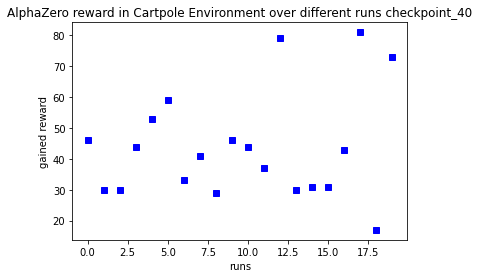

In [5]:
import matplotlib.pyplot as plt
plt.plot(reward_list,'bs')
plt.ylabel('gained reward')
plt.xlabel('runs')
plt.title('AlphaZero reward in Cartpole Environment over different runs checkpoint_40')
plt.show()